In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization,
    GlobalAveragePooling2D, Reshape, multiply, Add, Activation,concatenate,ReLU,
    DepthwiseConv2D, SeparableConv2D  # Import DepthwiseConv2D here
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
import datetime
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

In [2]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [3]:
dataset_path = "D:\\download\\JPEGImages (2)\\aaa"
num_classes=20

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.4) # 30% for validation

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(64, 64),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

Found 11999 images belonging to 20 classes.
Found 7998 images belonging to 20 classes.


In [5]:
def squeeze_excite_block(input, ratio=16):
    ''' Create a squeeze and excitation block
    Args:
        input: input tensor
        ratio: reduction ratio
    Returns: a keras tensor
    '''
    init = input
    channel_axis = -1 if K.image_data_format() == 'channels_last' else 1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)

    x = multiply([init, se])
    return x


In [6]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv2D(filters, kernel_size, padding='same', strides=stride)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x


In [7]:
# Now let's add the SE block to your model architecture
input_layer = Input(shape=(64, 64, 3))

# Convolutional layers with SE blocks
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = DepthwiseConv2D((3, 3), activation='relu', padding='same')(x)
x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)  # pointwise convolution
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)  # SE block


x = Conv2D(64, (3, 3), activation='relu')(x)
x = DepthwiseConv2D((3, 3), activation='relu', padding='same')(x)
x = Conv2D(64, (1, 1), activation='relu', padding='same')(x)  # pointwise convolution
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)  # SE block


x = Conv2D(128, (3, 3), activation='relu')(x)
x = DepthwiseConv2D((3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (1, 1), activation='relu', padding='same')(x)  # pointwise convolution
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)  # SE block

x = Conv2D(256, (3, 3), activation='relu')(x)
x = DepthwiseConv2D((3, 3), activation='relu', padding='same')(x)
x = Conv2D(256, (1, 1), activation='relu', padding='same')(x)  # pointwise convolution
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)
x = squeeze_excite_block(x)  # SE block

# Flatten and Dense layers
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation='softmax')(x)   # Update the number of classes

# Create model
model = Model(inputs=input_layer, outputs=output_layer)


In [8]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [9]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=50,  # You can change the number of epochs
    callbacks=[tensorboard_callback])  # Add the callback here


Epoch 1/50
374/374 [==============================] - 317s 832ms/step - loss: 2.9888 - accuracy: 0.0604 - val_loss: 2.9959 - val_accuracy: 0.0502
Epoch 2/50
374/374 [==============================] - 177s 473ms/step - loss: 2.9491 - accuracy: 0.0882 - val_loss: 2.9518 - val_accuracy: 0.0921
Epoch 3/50
374/374 [==============================] - 178s 475ms/step - loss: 2.9169 - accuracy: 0.0998 - val_loss: 2.8960 - val_accuracy: 0.1172
Epoch 4/50
374/374 [==============================] - 177s 473ms/step - loss: 2.8860 - accuracy: 0.1128 - val_loss: 2.8585 - val_accuracy: 0.1266
Epoch 5/50
374/374 [==============================] - 177s 473ms/step - loss: 2.8634 - accuracy: 0.1197 - val_loss: 2.8461 - val_accuracy: 0.1232
Epoch 6/50
374/374 [==============================] - 177s 472ms/step - loss: 2.8364 - accuracy: 0.1335 - val_loss: 2.8013 - val_accuracy: 0.1486
Epoch 7/50
374/374 [==============================] - 177s 473ms/step - loss: 2.8035 - accuracy: 0.1447 - val_loss: 2.7873 -

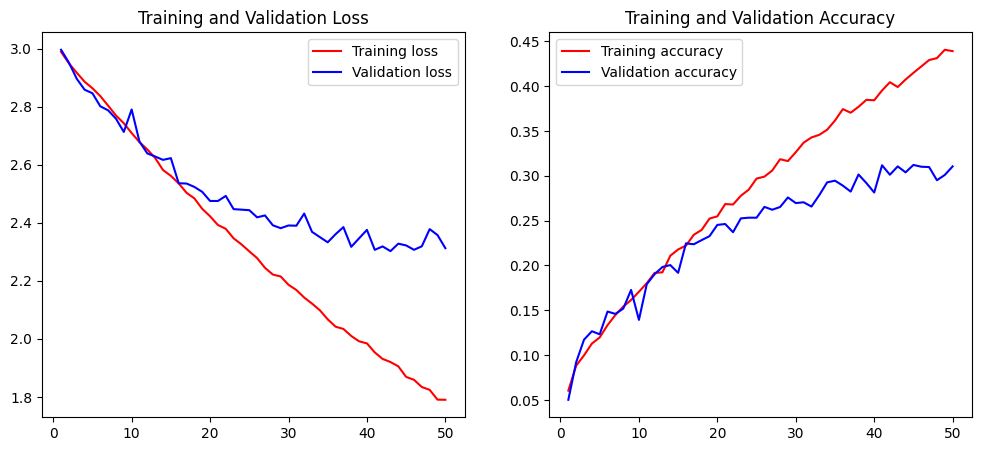

In [10]:
# 保存 history 对象的数据以便之后分析
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

# 可选：绘制训练和验证损失/准确度
import matplotlib.pyplot as plt

epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()

In [11]:
%load_ext tensorboard

%tensorboard --logdir logs/fit


In [14]:
model.save('vehicle_logo_dscnn_model.h5')
model_path = 'vehicle_logo_dscnn_model.h5'

In [15]:
from tensorflow.keras.preprocessing import image
# Load the trained model
model = tf.keras.models.load_model(model_path)

def predict_vehicle_logo(image_path, model):
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # 为批处理添加一个维度
    img_array /= 255.0  # 与训练时相同的缩放

    # 预测
    predictions = model.predict(img_array)
    class_index = np.argmax(predictions, axis=1)[0]

    # 类别标签
    labels = ['AUDI', 'BAOJUN', 'Benz', 'BMW', 'Buick', 'BYD', 'Cadillac', 'Changan', 'CHERY', 'Chevrolet', 
              'Citroen', 'Coupe', 'FAWHaima', 'Ford', 'Geely', 'GMC', 'HAVAL', 'HONDA', 'Hyundai', 'INFINITI', 
              'JEEP', 'KIA', 'Lexus', 'Lincoln', 'Mazda', 'MG', 'Mitsubishi', 'Nissan', 'PEUGEOT', 'Porsche', 
              'Qoros', 'RANGEROVER', 'Renault', 'ROEWE', 'Saab', 'SKODA', 'SoueastMotor', 'Subaru', 'SUZUKI', 
              'TOYOTA', 'TRUMCHI', 'Venucia', 'Volkswagen', 'VOLVO', 'WuLing']

    predicted_label = labels[class_index]
    return predicted_label



In [17]:
# Assuming your model's filename is 'vehicle_logo_dscnn_model.h5'

image_path = 'D:\\download\\JPEGImages (2)\\test\\GMC\\000350.jpg'
# Run the prediction function
result = predict_vehicle_logo(image_path, model)
print(f"The image at {image_path} is predicted to be a {result}.")

1/1 [==============================] - 0s 26ms/step
The image at D:\download\JPEGImages (2)\test\GMC\000350.jpg is predicted to be a Chevrolet.


In [18]:
image_path1 = 'D:\\download\\JPEGImages (2)\\test\\JEEP\\025632.jpg'
# Run the prediction function
result = predict_vehicle_logo(image_path1, model)
print(f"The image at {image_path} is predicted to be a {result}.")

1/1 [==============================] - 0s 28ms/step
The image at D:\download\JPEGImages (2)\test\GMC\000350.jpg is predicted to be a Geely.


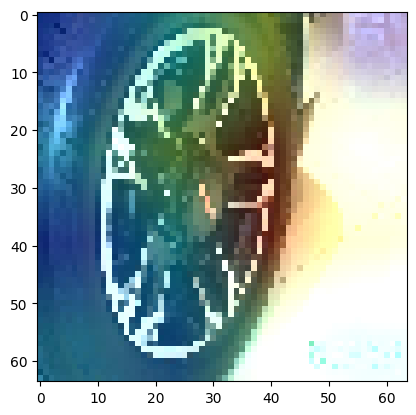

In [19]:
import cv2
import numpy as np
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, heatmap, alpha=0.4):
    # Load the original image
    img = cv2.imread(img_path)
    img = cv2.resize(img, (64, 64))

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Resize the heatmap to match the size of the image
    jet = cv2.resize(jet, (img.shape[1], img.shape[0]))

    # Create an image with RGB colorized heatmap
    superimposed_img = jet * alpha + img

    # Ensure the superimposed image is of type float32, then convert to [0,255] integer type
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    # Convert color from BGR to RGB
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

    # Display Image
    plt.imshow(superimposed_img)
    plt.show()



# Use the function with an example
last_conv_layer_name = "conv2d_7"  # You should set the name of the last convolutional layer of your model
img_array = img_to_array(load_img(image_path, target_size=(64, 64)))  # Load your image
img_array = np.expand_dims(img_array, axis=0)  # Make it a batch
img_array /= 255.0  # Normalize

# Generate the heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display the heatmap
display_gradcam(image_path, heatmap)
